**TODO** (if time allows):
- add different types of ray sampling

**IDEA**:
- A WAY TO CHECK IF PLUCKER EMBED IS CORRECT CAN BE BY COMPUTING THE CHANGES IN PLUCKER EMBEDDINGS AND COMPUTE THE K,P VALUES BACK AND SEE IF THEY CORRESPOND TO THAT OPERATION. This is for the augmentation part.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.data import get_camera_params_for_file, get_plucker_embedding, parse_directory, save_data

# Example 

Let's have a look at an example of how we're processing the data. 

**PS**: videos have 16:9 resolution. Let's take one ray per pixel in this minimal resolution, i.e. 16 rays horizontally and 9 rays vertically (144 total rays). We do this for efficiency for now, we can always scale it up if necessary.

In [2]:
file_path = "../RealEstate10K/train/0000cc6d8b108390.txt"

url, K, timesteps, extrinsics = get_camera_params_for_file(file_path)
frame_idx = 0
P = extrinsics[frame_idx]

In [3]:
print(f"URL: {url}")
print(f"K shape: {K.shape}\nK: {K}")
print(f"Number of frames shape: {len(timesteps)}\nMicroseconds since start of video: {timesteps[:5]} etc...")
print(f"Frame {frame_idx} --> P shape: {P.shape}\nP: {P}")

URL: https://www.youtube.com/watch?v=KeXr_qWVbiU
K shape: torch.Size([3, 3])
K: tensor([[0.5110, 0.0000, 0.5000],
        [0.0000, 0.9084, 0.5000],
        [0.0000, 0.0000, 1.0000]])
Number of frames shape: 218
Microseconds since start of video: [52553000 52586000 52619000 52653000 52686000] etc...
Frame 0 --> P shape: torch.Size([3, 4])
P: tensor([[ 0.9999,  0.0044, -0.0106, -0.1363],
        [-0.0043,  1.0000,  0.0030,  0.0233],
        [ 0.0107, -0.0029,  0.9999, -0.3366]])


In [4]:
K_inv = torch.linalg.inv(K)
num_rays_x, num_rays_y = 16, 9
num_rays = num_rays_x * num_rays_y
ray_directions, plucker_moments = get_plucker_embedding(K_inv, P, num_rays_x, num_rays_y)
print(f"Total number of rays: {num_rays}")
print(f"ray_directions shape: {ray_directions.shape}")
print(f"plucker_moments shape: {plucker_moments.shape}")
ray_idx = np.random.randint(0, num_rays)
print(f"Example of (d, m) in a random ray: d={ray_directions[ray_idx]}, m={plucker_moments[ray_idx]}")

Total number of rays: 144
ray_directions shape: torch.Size([144, 3])
plucker_moments shape: torch.Size([144, 3])
Example of (d, m) in a random ray: d=tensor([-0.1513, -0.4369,  0.8867]), m=tensor([ 0.1254, -0.1748, -0.0648])


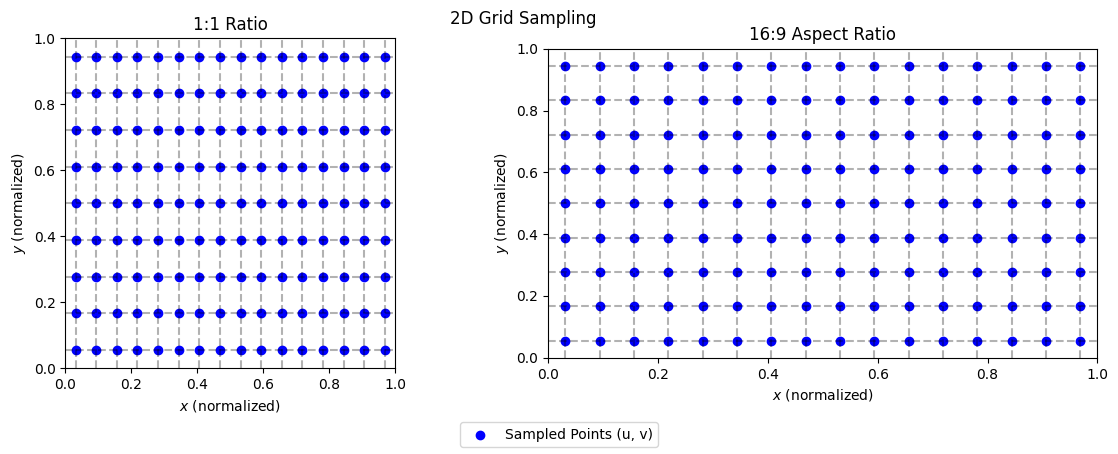

In [5]:
u = np.linspace(0, 1, num_rays_x, endpoint=False) + 0.5 / num_rays_x
v = np.linspace(0, 1, num_rays_y, endpoint=False) + 0.5 / num_rays_y
U, V = np.meshgrid(u, v)
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# 1:1 plot
sc1 = axs[0].scatter(U, V, color='blue', label='Sampled Points (u, v)')
for i in range(num_rays_x):
    axs[0].plot([u[i], u[i]], [0, 1], 'k--', alpha=0.3)  # Vertical lines
for j in range(num_rays_y):
    axs[0].plot([0, 1], [v[j], v[j]], 'k--', alpha=0.3)  # Horizontal lines
axs[0].set_xlabel("$x$ (normalized)")
axs[0].set_ylabel("$y$ (normalized)")
axs[0].set_title("1:1 Ratio")
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].set_aspect('equal')  # Normalized square aspect ratio

# 16:9 plot
sc2 = axs[1].scatter(U, V, color='blue', label='Sampled Points (u, v)')
for i in range(num_rays_x):
    axs[1].plot([u[i], u[i]], [0, 1], 'k--', alpha=0.3)  # Vertical lines
for j in range(num_rays_y):
    axs[1].plot([0, 1], [v[j], v[j]], 'k--', alpha=0.3)  # Horizontal lines
axs[1].set_xlabel("$x$ (normalized)")
axs[1].set_ylabel("$y$ (normalized)")
axs[1].set_title("16:9 Aspect Ratio")
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_aspect(9/16)  # True 16:9 aspect ratio

fig.legend(handles=[sc1], labels=['Sampled Points (u, v)'], loc='lower center', ncol=1) # Create a single legend for the figure
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make space for legend at the bottom
plt.suptitle("2D Grid Sampling")
plt.show()

In [6]:
show_3d_plot = False
if show_3d_plot:
    import plotly.graph_objects as go 
    
    # Extract camera center (origin) for visualization
    R, t = P[:, :3], P[:, 3]
    camera_center = (-R.T @ t).numpy()
    ray_dirs_np = ray_directions.numpy()

    # Create figure
    fig = go.Figure()
    # Add camera center
    fig.add_trace(go.Scatter3d(
        x=[camera_center[0]], y=[camera_center[1]], z=[camera_center[2]],
        mode='markers', marker=dict(size=6, color='red'),
        name='Camera Center'
    ))
    # Add rays as lines
    for i in range(ray_dirs_np.shape[0]):
        d = ray_dirs_np[i]
        fig.add_trace(go.Scatter3d(
            x=[camera_center[0], camera_center[0] + d[0]],
            y=[camera_center[1], camera_center[1] + d[1]],
            z=[camera_center[2], camera_center[2] + d[2]],
            mode='lines', line=dict(color='blue', width=2),
            opacity=0.6
        ))

    # Layout adjustments
    fig.update_layout(
        title="Interactive 3D Visualization of Rays (16x9)",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode='auto'
        ),
        showlegend=False
    )

    fig.show()

# Data Extraction

Here we extract the data with the camera model matrices and Plücker embeddings for training and testing from the RealEstate10k dataset.

In [7]:
test_data_small = parse_directory("../RealEstate10K/test", subset_size=0.2)
save_data(test_data_small, "data/test_small.pkl")
# not pushed to git repo for memory reasons

Processing RealEstate10K files: 100%|██████████| 1542/1542 [00:41<00:00, 37.13file/s]


Data successfully saved to data/test_small.pkl


In [8]:
train_data_small = parse_directory("../RealEstate10K/train", subset_size=0.2)
save_data(train_data_small, "data/train_small.pkl")
# not pushed to git repo for memory reasons

Processing RealEstate10K files:   0%|          | 0/14311 [00:00<?, ?file/s]

Processing RealEstate10K files: 100%|██████████| 14311/14311 [06:19<00:00, 37.76file/s]


Data successfully saved to data/train_small.pkl
